# WorldCup 2018 Analysis

In this notebook, I would like to analyze 3 last games of the World Cup 2018.  
*  France vs Belgium (1st semi-final)
* Croatia vs England (2nd semi-final)
* France vs Croatia (final)

### Here are my plans:
1. Import the dataset
1. Set up the teams
1. Compare between teams based on: value, forward, midfielder, defender, goalkeeper , overall, and history games
1. Make prediction before the game
1. Compare the prediction and the result

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

from plotly.offline import iplot, init_notebook_mode
from geopy.geocoders import Nominatim
import plotly.plotly as py

import os
print(os.listdir("../input"))


['worldcup2018', 'fifa-18-demo-player-dataset']


# 1. Data Preparation
## 1.1 Load Data

In [2]:
df = pd.read_csv("../input/fifa-18-demo-player-dataset/CompleteDataset.csv", index_col=0)
df.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.



,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,Preferred Positions,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,€565K,2228,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88,89.0,53.0,62.0,91.0,82.0,20801,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,ST LW,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,€565K,2154,92,48,90,95,95,96,77,89,97,95,90,6,11,15,14,8,71,22,68,87,88,13,74,93,95,88,85,26,87,73,28,59,90,85,92.0,45.0,59.0,92.0,84.0,158023,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,RW,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,€280K,2100,94,56,96,82,95,92,75,81,96,89,84,9,9,15,15,11,62,36,61,75,77,21,81,90,88,81,80,33,90,78,24,53,80,83,88.0,46.0,59.0,88.0,79.0,190871,88.0,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,LW,88.0,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€97M,€510K,2291,88,78,86,60,91,83,77,86,86,94,84,27,25,31,33,37,77,41,69,64,86,30,85,92,93,83,87,38,77,89,45,80,84,88,87.0,58.0,65.0,88.0,80.0,176580,87.0,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,ST,87.0,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,€61M,€230K,1493,58,29,52,35,48,70,15,14,30,13,11,91,90,95,91,89,25,30,78,59,16,10,47,12,85,55,25,11,61,44,10,83,70,11,NaN,NaN,NaN,NaN,NaN,167495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
columns = ['Name','Age','Nationality','Overall','Value']
data = pd.DataFrame(df,columns=columns)
data.head()

,Name,Age,Nationality,Overall,Value
0,Cristiano Ronaldo,32,Portugal,94,€95.5M
1,L. Messi,30,Argentina,93,€105M
2,Neymar,25,Brazil,92,€123M
3,L. Suárez,30,Uruguay,92,€97M
4,M. Neuer,31,Germany,92,€61M


## 1.2 Summarize Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17981 entries, 0 to 17980
Data columns (total 5 columns):
Name           17981 non-null object
Age            17981 non-null int64
Nationality    17981 non-null object
Overall        17981 non-null int64
Value          17981 non-null object
dtypes: int64(2), object(3)
memory usage: 842.9+ KB


## 1.3 Preprocess Data

I will change the Value column from string to integer by removing € and M (or K).

In [5]:
# Supporting function for converting string values into numbers
def str2number(amount):
    if amount[-1] == 'M':
        return float(amount[1:-1])*1000000
    elif amount[-1] == 'K':
        return float(amount[1:-1])*1000
    else:
        return float(amount[1:])
    
data['Value'] = data['Value'].apply(lambda x: str2number(x))


# 2. Data Visualization
## 2.1 Age

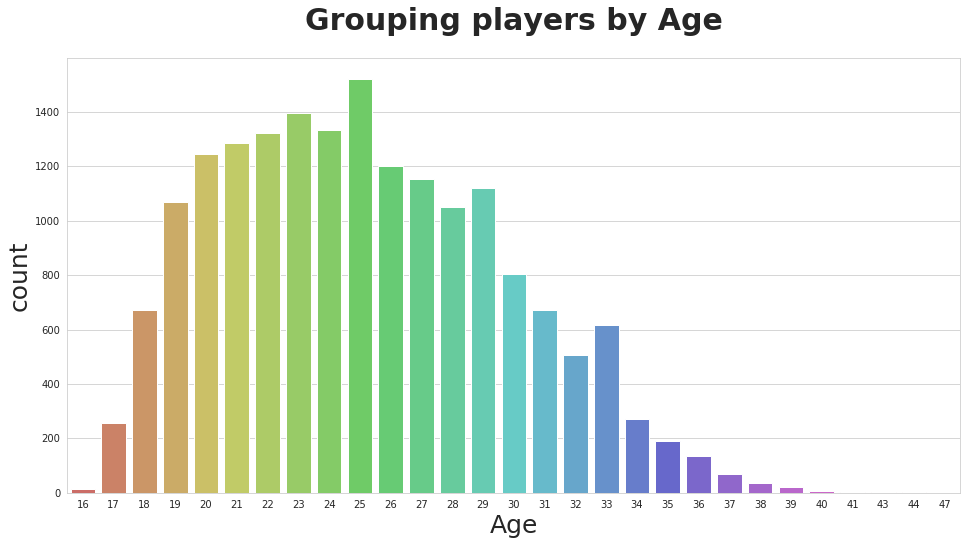

In [6]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('Grouping players by Age', fontsize=30, fontweight='bold', y=1.05,)
plt.xlabel('Age',fontsize=25)
plt.ylabel('Count',fontsize=25)
sns.countplot(x="Age", data=data, palette="hls");
plt.show()

Looking the graph above, I see players come from all ages.  I believe players can perform best when they are at age 20 to 29.  If they are younger than 20, they dont have a lot of experience.  If they are older than 29, they probably dont have enough strength.  So, I will deduct 5% overall score if players are younger than 20.  I deduct 3% overall score if players are older than 29.  Oder players dont have enough strength compare to younger players, but they have more experience.  That's why I deduct only 3% for older players.

## 2.2 Overall

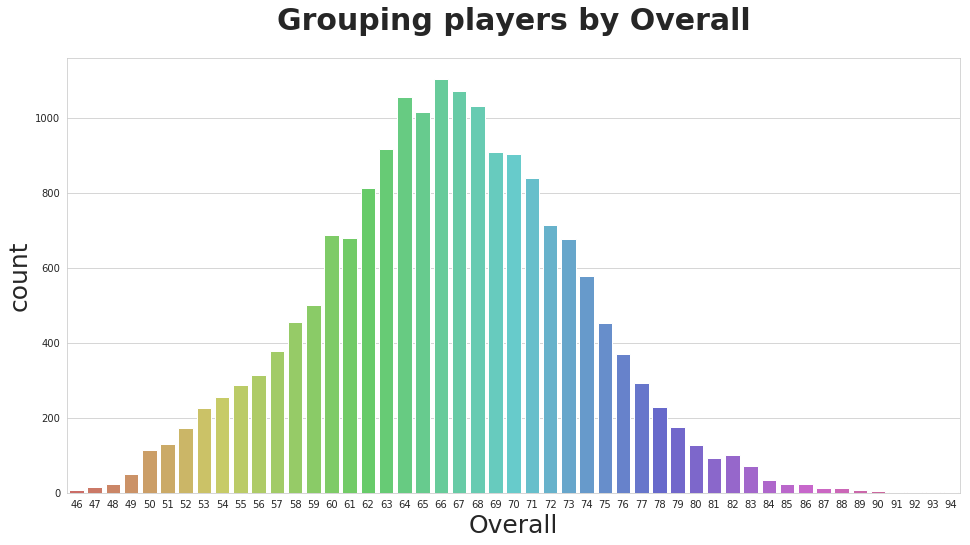

In [7]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('Grouping players by Overall', fontsize=30, fontweight='bold', y=1.05,)
plt.xlabel('Number of players', fontsize=25)
plt.ylabel('Players Age', fontsize=25)
sns.countplot(x="Overall", data=data, palette="hls");
plt.show()

In [8]:
data.Overall.describe()

count    17981.000000
mean        66.247984
std          6.987965
min         46.000000
25%         62.000000
50%         66.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64

In [9]:
player_over_80 = len(data[data.Overall > 80])*100/len(data)
print('The percentage of players who have overall score greater than 80 is only {:.1f}%'.format(player_over_80))
print('Most players who play in Worldcup games have overall score obove 80.')

The percentage of players who have overall score greater than 80 is only 2.2%
Most players who play in Worldcup games have overall score obove 80.


The overall score is range from 46 to 94 points.  Majority of the score is from 62 to 71.   

## 2.3 Nationality

In [10]:
'''
a = data.Nationality.value_counts().reset_index()
a.columns=['Nationality','Count']
a[:20]
'''
top20_nation = data.groupby('Nationality').size().reset_index(name='Count').sort_values('Count',ascending = False)[:20]
top20_nation

,Nationality,Count
45,England,1630
58,Germany,1140
137,Spain,1019
54,France,978
5,Argentina,965
18,Brazil,812
77,Italy,799
30,Colombia,592
80,Japan,469
107,Netherlands,429


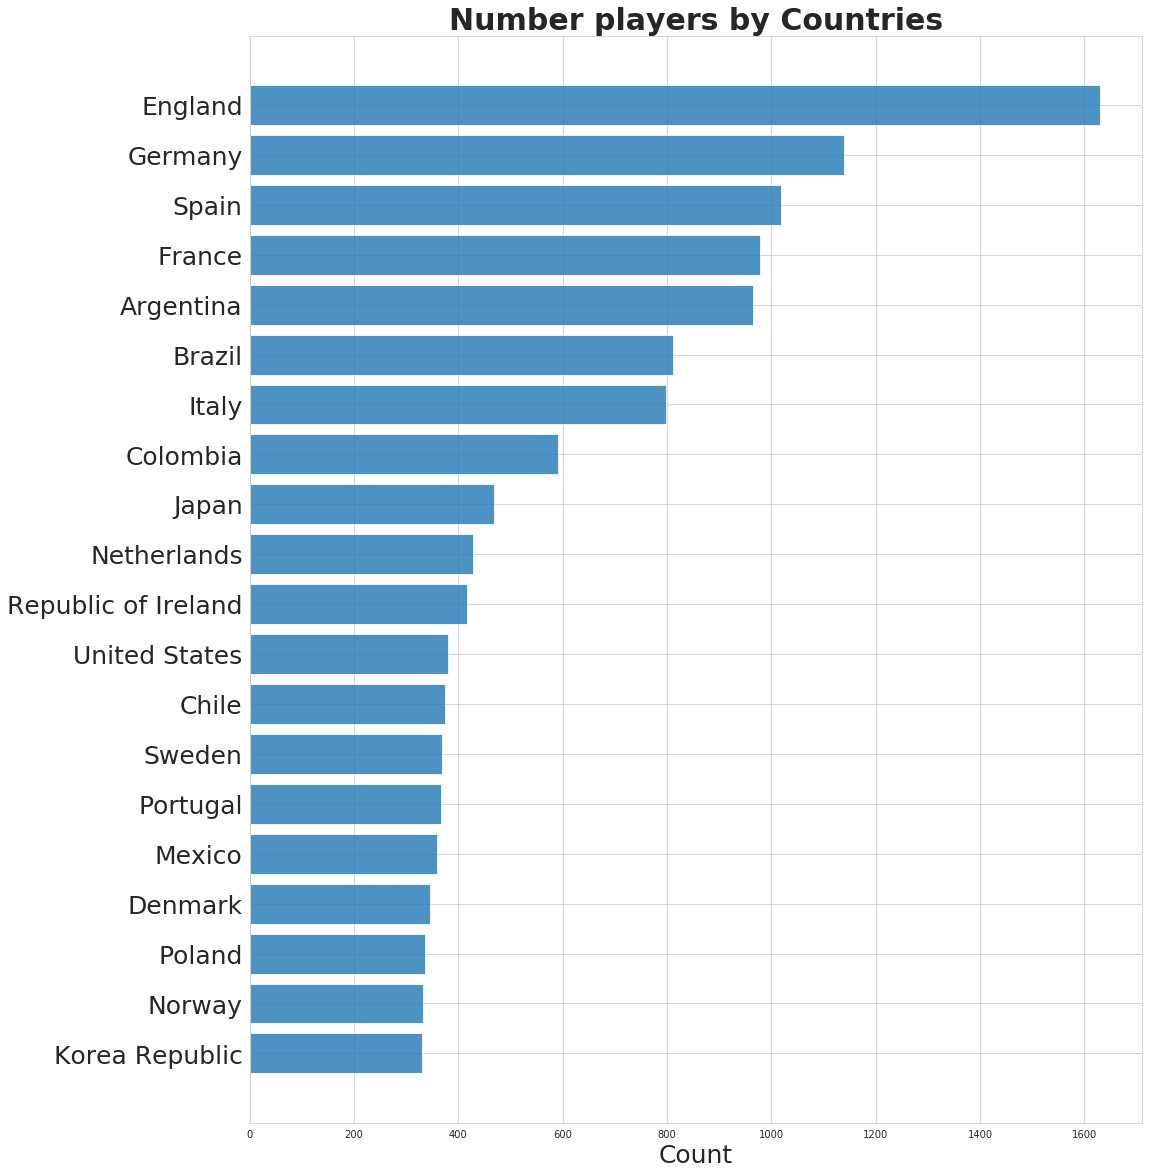

In [11]:
plt.figure(figsize=(16,20))

countries = list(top20_nation.loc[::-1,'Nationality'])
pos = np.arange(len(countries))
count = list(top20_nation.loc[::-1,'Count'])

plt.barh(pos, count, align='center', alpha=.8)
plt.yticks(pos, countries, fontsize=25)
plt.xlabel('Count', fontsize=25)
plt.title('Number players by Countries', fontsize=30, fontweight='bold')
 
plt.show()

England has the most players.  It has about 500 players more than Germany (2nd).  

## 2.4 Relationship between Value and Age 

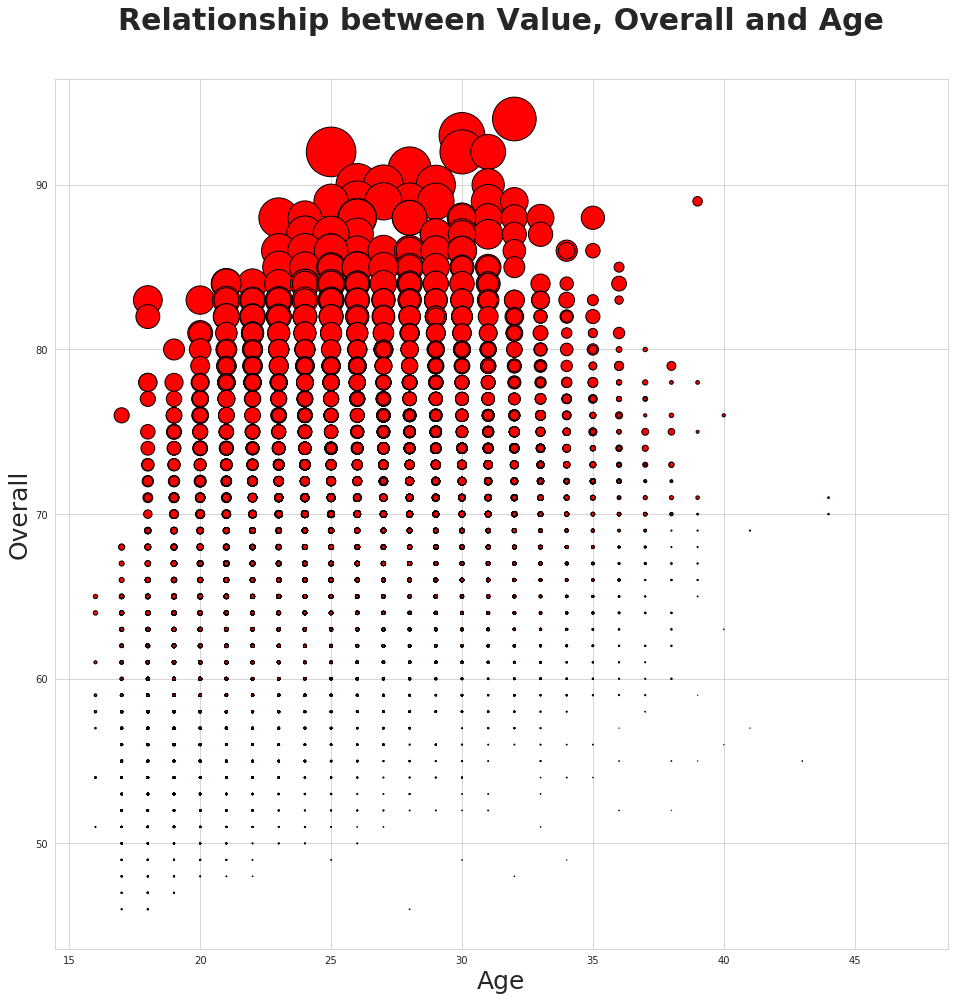

In [12]:
plt.figure(figsize=(16,16))
sns.set_style("whitegrid")
plt.title('Relationship between Value, Overall and Age', fontsize=30, fontweight='bold', y=1.05,)
plt.xlabel('Age', fontsize=25)
plt.ylabel('Overall', fontsize=25)

age = data["Age"].values
overall = data["Overall"].values
value = data["Value"].values

plt.scatter(age, overall, s = value/50000, edgecolors='black', color="red")
plt.show()

* Players with overall score above 75 have value
* At younger age, players dont have high overall score.  The highest score is under 85.
* As age inceasing, players have more experience, so the overall score inscreases, the value inscreases until age 33.
* When players get older, their scores and values decrease after the age 33.
* The age from 25 to 33 is a great time for a player to shine.


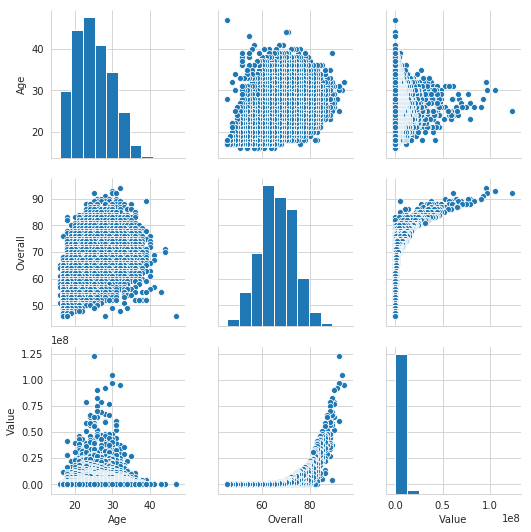

In [13]:
sns.pairplot(data[['Age','Overall','Value']])

## 2.5 Relationship between Overall and Value

In [14]:
data['AgeRange'] = pd.cut(data.Age, bins = [0,23,33,45],labels = ['Young','Mature','Old'])

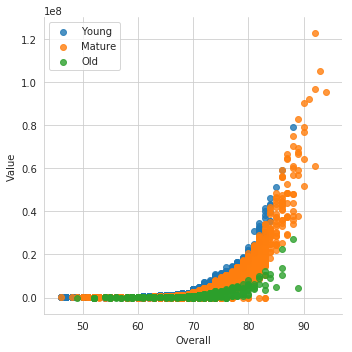

In [15]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="Overall", y="Value", data=data, fit_reg=False, hue='AgeRange', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper left')


Looking at the graph above, I see older player's values are lowest because they will be retire soon.  The mature players can earn a lot more value.  Their values are highest.  The younger players values are at second place, because they are young.  As they are getting older, their values might increase.

## 2.6 Percentages between Young, Mature, and Old Players

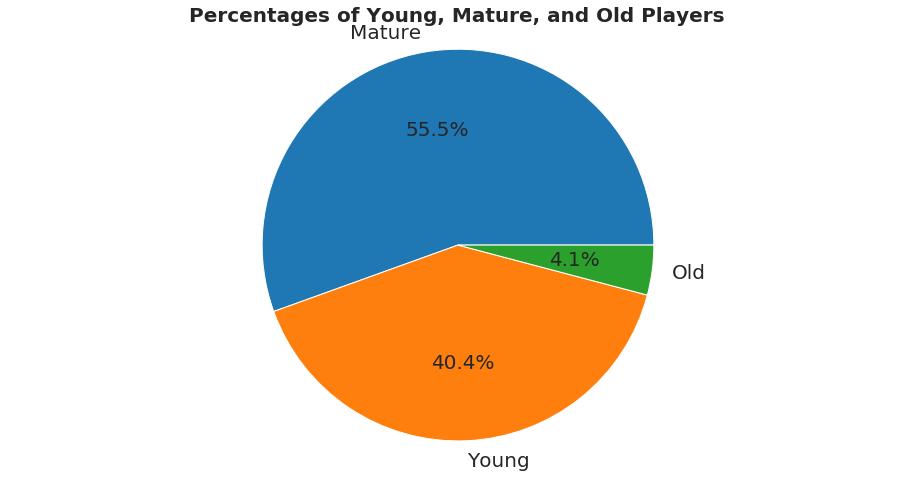

In [16]:
plt.figure(figsize=(16,8))
plt.title("Percentages of Young, Mature, and Old Players", fontsize = 20, fontweight = 'bold')
labels = 'Mature','Young','Old'
plt.rcParams['font.size'] = 20.0
plt.pie(data.AgeRange.value_counts(), labels = labels, autopct='%1.1f%%', startangle=0)
plt.axis('equal')
plt.show()

* Players who are older than 33 years old are only 4.1% of the player pool.  Not a lot of players still play after they are 33 year old.  Most of players would be retired before 33 years old.
* Young players and Mature players have 40.4% and 55.5% respectively.  

## 2.6 Value of Top 20 players in each Top 10 Countries

In [17]:
def get_top20_players(country):
    top20players = data[data.Nationality == country].sort_values('Value',ascending = False)[:20]
    return top20players

top10_nation_list = top20_nation.Nationality[:10].tolist()

frames = []
for i in range(len(top10_nation_list)):
    temp_df = get_top20_players(top10_nation_list[i])
    frames.append(temp_df)
top_players_in_top10 = pd.concat(frames)
top_players_in_top10.head(3)

,Name,Age,Nationality,Overall,Value,AgeRange
46,H. Kane,23,England,86,59000000.0,Young
96,D. Alli,21,England,84,43000000.0,Young
229,R. Sterling,22,England,82,29500000.0,Young


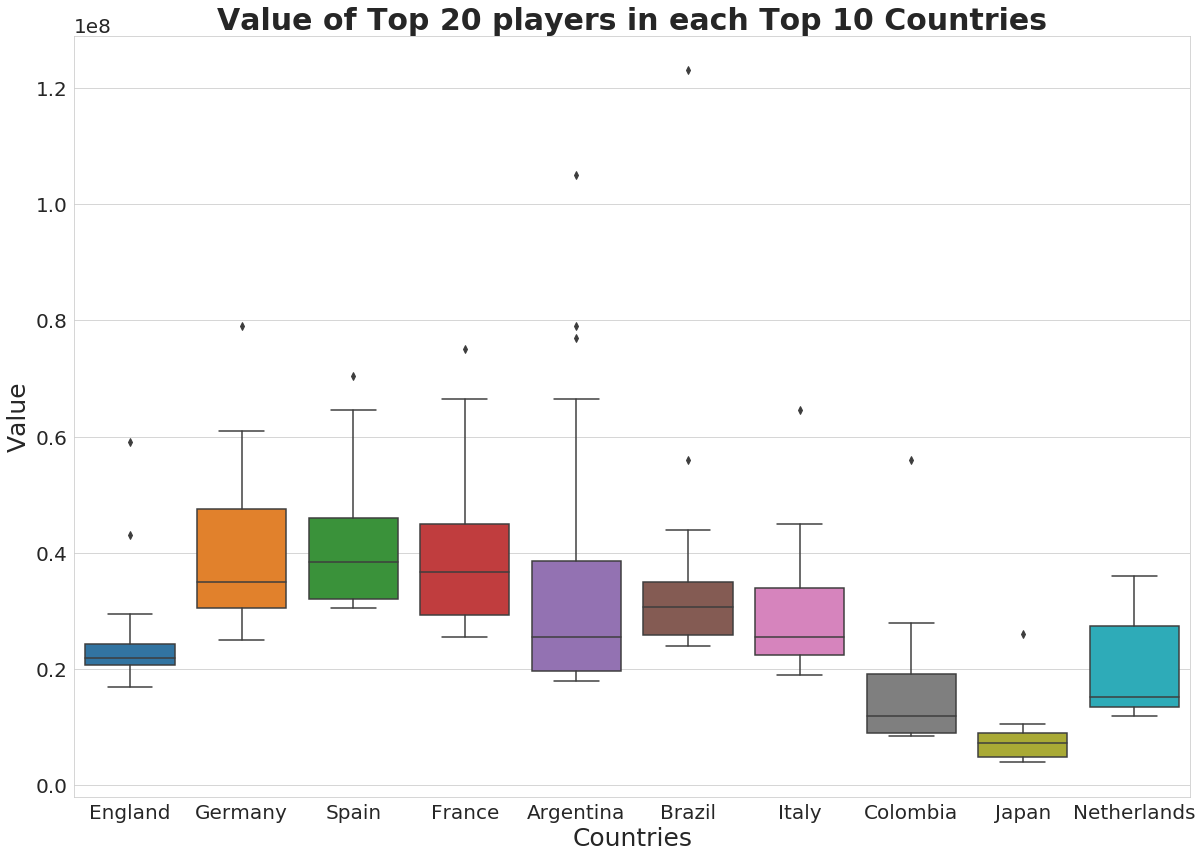

In [18]:
plt.figure(figsize=(20,14))
sns.boxplot(x="Nationality",y = 'Value',data = top_players_in_top10)
plt.title("Value of Top 20 players in each Top 10 Countries", fontsize = 30, fontweight = 'bold')
plt.xlabel('Countries', fontsize=25)
plt.ylabel('Value', fontsize=25)
plt.show()

Looking at the graph above:
* Brazil has one player who has highest value. 
* Players who are from England and Japan have value really close to their teammates.
* In term of median, Spain has the most value.

# 3. Match Analysis
The comparation is using only 11 players in lineups because

## 3.1 France vs Belgium ( 1 st quater final)

In [19]:
# define a function that get location of each players from a name list
def get_location(player_list,data):
    location=[]
    for idx,s in enumerate(data.Name):
        for player in player_list:
            if player in s:
                location.append(idx)
    return location


In [20]:
# Players who are younger than 20 will have 95% of their overall score
# Players who are older than 29 will have 98% of their overall score
def overall_adjusted_score(input_data):
    data = input_data.copy()
    data.loc[data.index[(data.Age < 20)],"Overall"]=data.loc[data.index[(data.Age < 20)],"Overall"]*0.95
    data.loc[data.index[(data.Age >29)],"Overall"]=data.loc[data.index[(data.Age >29)],"Overall"]*0.98
    return data.Overall.mean()

### 3.1.1 Teams Analysis

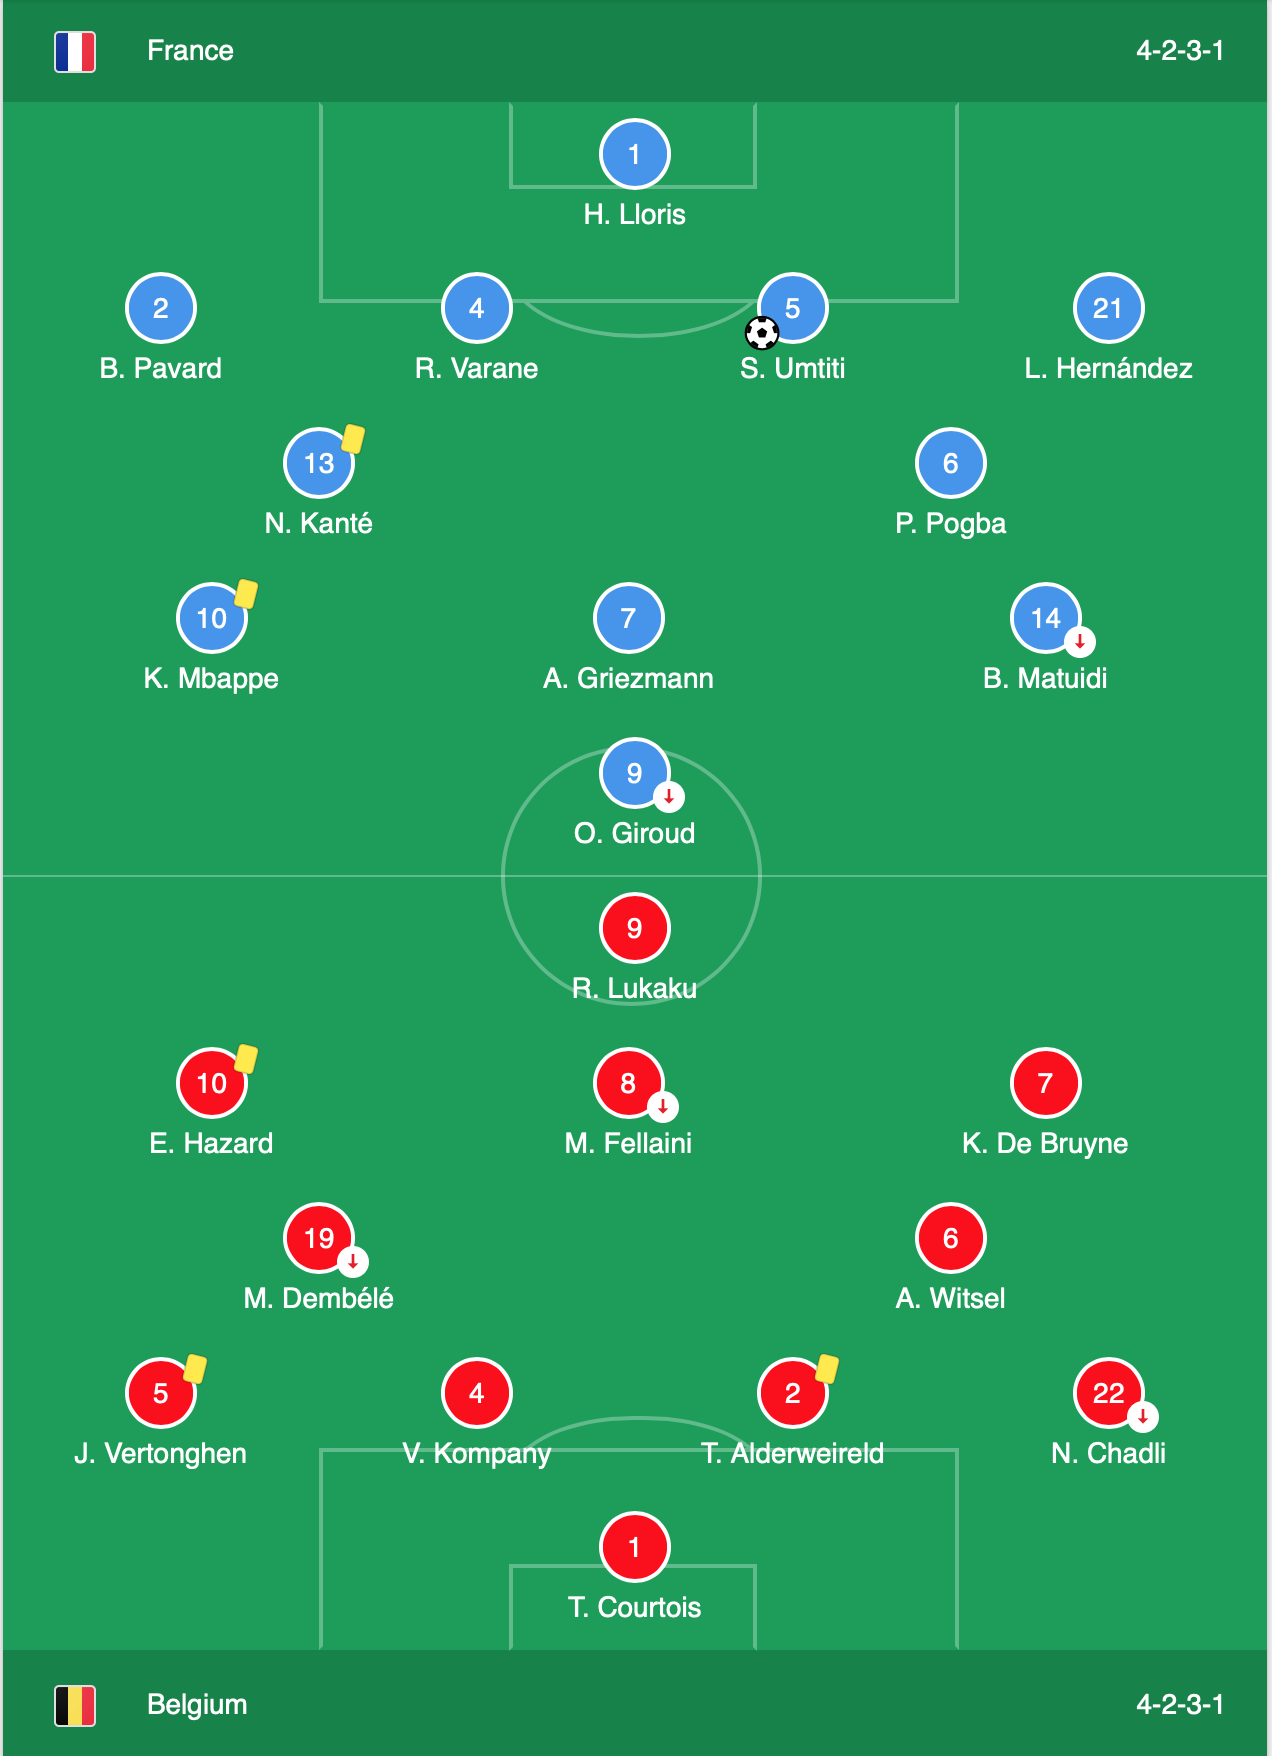

In [21]:
Image("../input/worldcup2018/FranceVsBelgium.png")

In [22]:
FrancePlayers = ["H. Lloris","B. Pavard","R. Varane","S. Umtiti","L. Hernandez","N. Kante","P. Pogba","K. Mbappe","A. Griezmann","B. Matuidi","O. Giroud"]
BelgiumPlayers = ["R. Lukaku","E. Hazard","M. Fellaini","K. De Bruyne","M. Dembele","A. Witsel","J. Vertonghen","V. Kompany","T. Alderweireld","N. Chadli","T. Courtois"]

In [23]:
all_france_players =data[data.Nationality == "France"]
France_lineups = all_france_players.iloc[get_location(FrancePlayers,all_france_players),:]
France_lineups


,Name,Age,Nationality,Overall,Value,AgeRange
21,A. Griezmann,26,France,88,75000000.0,Mature
29,H. Lloris,30,France,88,38000000.0,Mature
35,P. Pogba,24,France,87,66500000.0,Mature
70,R. Varane,24,France,85,46500000.0,Mature
87,B. Matuidi,30,France,85,28500000.0,Mature
142,S. Umtiti,23,France,83,29500000.0,Young
269,O. Giroud,30,France,82,21500000.0,Mature
3397,B. Pavard,21,France,72,3900000.0,Young


In France_lineups, we found only 8 players.  We are missing 3 more players who are L. Hernandez,  N. Kante, and K. Mbappe.  I found the data for those players on sofifa.com.

* K. Mbappe: age:20, Overall: 88, Value: 81M
* L. Hernandez: age:22, Overall: 83, Value: 29.5M
* N. Kante: age:27, Overall: 89, Value: 63M

In [24]:
# Add missing players to France_lineups dataframe
France_lineups=France_lineups.append({'Name' : 'K. Mbappe' , 'Age' : 20, 'Nationality': 'France', 'Overall' : 88, 'Value' : 81000000} , ignore_index=True)
France_lineups=France_lineups.append({'Name' : 'L. Hernandez' , 'Age' : 22, 'Nationality': 'France', 'Overall' : 83, 'Value' : 29500000} , ignore_index=True)
France_lineups=France_lineups.append({'Name' : 'N. Kante' , 'Age' : 27, 'Nationality': 'France', 'Overall' : 89, 'Value' : 63000000} , ignore_index=True)


In [25]:
# complete France Lineups
France_lineups

,Name,Age,Nationality,Overall,Value,AgeRange
0,A. Griezmann,26,France,88,75000000.0,Mature
1,H. Lloris,30,France,88,38000000.0,Mature
2,P. Pogba,24,France,87,66500000.0,Mature
3,R. Varane,24,France,85,46500000.0,Mature
4,B. Matuidi,30,France,85,28500000.0,Mature
5,S. Umtiti,23,France,83,29500000.0,Young
6,O. Giroud,30,France,82,21500000.0,Mature
7,B. Pavard,21,France,72,3900000.0,Young
8,K. Mbappe,20,France,88,81000000.0,NaN
9,L. Hernandez,22,France,83,29500000.0,NaN


In [26]:
# Belgium
all_belgium_players =data[data.Nationality == "Belgium"]
Belgium_lineups = all_belgium_players.iloc[get_location(BelgiumPlayers,all_belgium_players),:]
Belgium_lineups

,Name,Age,Nationality,Overall,Value,AgeRange
7,E. Hazard,26,Belgium,90,90500000.0,Mature
11,K. De Bruyne,26,Belgium,89,83000000.0,Mature
12,T. Courtois,25,Belgium,89,59000000.0,Mature
50,R. Lukaku,24,Belgium,86,59000000.0,Mature
56,T. Alderweireld,28,Belgium,86,40500000.0,Mature
86,J. Vertonghen,30,Belgium,85,28500000.0,Mature
90,V. Kompany,31,Belgium,85,26000000.0,Mature
274,A. Witsel,28,Belgium,82,0.0,Mature
645,M. Fellaini,29,Belgium,79,12000000.0,Mature
781,N. Chadli,27,Belgium,78,11000000.0,Mature


In Belgium lineups, I have 10 players.  We are missing one player who is M. Dembele. 

* M. Dembele: age:30, Overall: 82, Value: 0

In [27]:
# Add missing players to Belgium_lineups dataframe
Belgium_lineups=Belgium_lineups.append({'Name' : 'M. Dembele' , 'Age' : 30, 'Nationality': 'Belgium', 'Overall' : 82, 'Value' : 0} , ignore_index=True)
Belgium_lineups

,Name,Age,Nationality,Overall,Value,AgeRange
0,E. Hazard,26,Belgium,90,90500000.0,Mature
1,K. De Bruyne,26,Belgium,89,83000000.0,Mature
2,T. Courtois,25,Belgium,89,59000000.0,Mature
3,R. Lukaku,24,Belgium,86,59000000.0,Mature
4,T. Alderweireld,28,Belgium,86,40500000.0,Mature
5,J. Vertonghen,30,Belgium,85,28500000.0,Mature
6,V. Kompany,31,Belgium,85,26000000.0,Mature
7,A. Witsel,28,Belgium,82,0.0,Mature
8,M. Fellaini,29,Belgium,79,12000000.0,Mature
9,N. Chadli,27,Belgium,78,11000000.0,Mature


### Age

In [28]:
print("Here is France's average age: {:.2f},comparing against Belgium's average age: {:.2f}.".format(France_lineups.Age.mean(),Belgium_lineups.Age.mean()))
print("We can see France players are younger than Belgium players on average. It means Belgium have more experiences than France. France players are youngers, so they have more strength.")

Here is France's average age: 25.18,comparing against Belgium's average age: 27.64.
We can see France players are younger than Belgium players on average. It means Belgium have more experiences than France. France players are youngers, so they have more strength.


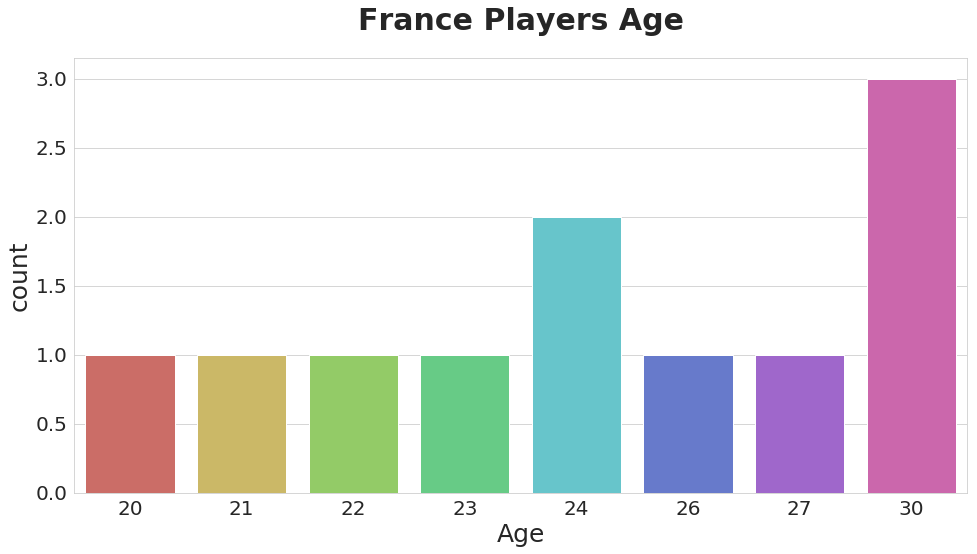

In [29]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('France Players Age', fontsize=30, fontweight='bold', y=1.05,)
plt.xlabel('x', fontsize=25)
plt.ylabel('y', fontsize=25)
sns.countplot(x="Age", data=France_lineups, palette="hls");
plt.show()

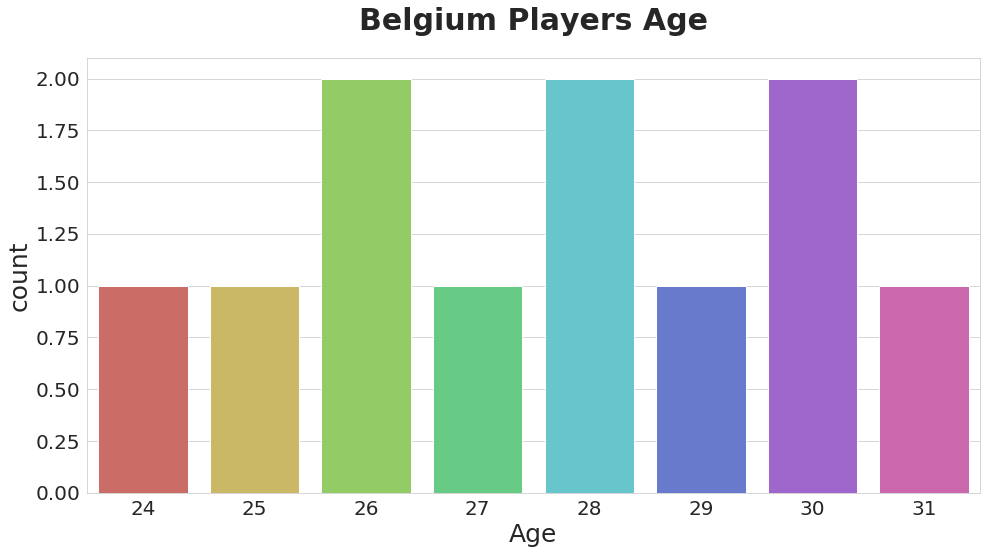

In [30]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
plt.title('Belgium Players Age', fontsize=30, fontweight='bold', y=1.05,)
plt.xlabel('x', fontsize=25)
plt.ylabel('y', fontsize=25)
sns.countplot(x="Age", data=Belgium_lineups, palette="hls");
plt.show()

### Value

I will replace the value of A. Witsel and M. Dembele with Belgium's average value .

In [31]:
names = ['A. Witsel','M. Dembele']
mean = Belgium_lineups.Value.mean()
Belgium_lineups.loc[get_location(names,Belgium_lineups),'Value'] = mean
Belgium_lineups

,Name,Age,Nationality,Overall,Value,AgeRange
0,E. Hazard,26,Belgium,90,9.050000e+07,Mature
1,K. De Bruyne,26,Belgium,89,8.300000e+07,Mature
2,T. Courtois,25,Belgium,89,5.900000e+07,Mature
3,R. Lukaku,24,Belgium,86,5.900000e+07,Mature
4,T. Alderweireld,28,Belgium,86,4.050000e+07,Mature
5,J. Vertonghen,30,Belgium,85,2.850000e+07,Mature
6,V. Kompany,31,Belgium,85,2.600000e+07,Mature
7,A. Witsel,28,Belgium,82,3.722727e+07,Mature
8,M. Fellaini,29,Belgium,79,1.200000e+07,Mature
9,N. Chadli,27,Belgium,78,1.100000e+07,Mature


In [32]:
print('Here is total value of France: €{:.2f}M, \nand here is total value of Belgium: €{:.2f}M'.format(France_lineups.Value.sum()/1000000,Belgium_lineups.Value.sum()/1000000))


Here is total value of France: €482.90M, 
and here is total value of Belgium: €483.95M


Belgium have one point here because its total value is greater than France's total value.

### Forward

In [33]:
France_Forward_Players = ["K. Mbappe","A. Griezmann","B. Matuidi","O. Giroud"]
Belgium_Forward_Players = ["R. Lukaku","E. Hazard","M. Fellaini","K. De Bruyne"]

In [34]:
France_Forward_Lineups=France_lineups.iloc[get_location(France_Forward_Players,France_lineups),:]
Belgium_Forward_Lineups=Belgium_lineups.iloc[get_location(Belgium_Forward_Players,Belgium_lineups),:]

In [35]:
print("With adjusted overall score for forward lineups, France's average Overall score: {:.2f},comparing against Belgium's average Overall score: {:.2f}.".format(overall_adjusted_score(France_Forward_Lineups),overall_adjusted_score(Belgium_Forward_Lineups)))

With adjusted overall score for forward lineups, France's average Overall score: 84.92,comparing against Belgium's average Overall score: 86.00.


Belgium's forward players are stronger than France's, so Belgium receives one point.

### Midfielder

In [36]:
France_Midfielder_Players = ["N. Kante","P. Pogba"]
Belgium_Midfielder_Players = ["M. Dembele","A. Witsel"]

In [37]:
France_Midfielder_Lineups=France_lineups.iloc[get_location(France_Midfielder_Players,France_lineups),:]
Belgium_Midfielder_Lineups=Belgium_lineups.iloc[get_location(Belgium_Midfielder_Players,Belgium_lineups),:]

In [38]:
print("With adjusted overall score for midfielder lineups, France's average Overall score: {:.2f},comparing against Belgium's average Overall score: {:.2f}.".format(overall_adjusted_score(France_Midfielder_Lineups),overall_adjusted_score(Belgium_Midfielder_Lineups)))

With adjusted overall score for midfielder lineups, France's average Overall score: 88.00,comparing against Belgium's average Overall score: 81.18.


France's midfield players are stronger than Belgium's, so France receives one point.

### Defender

In [39]:
France_Defender_Players = ["B. Pavard","R. Varane","S. Umtiti","L. Hernandez"]
Belgium_Defender_Players = ["J. Vertonghen","V. Kompany","T. Alderweireld","N. Chadli"]

In [40]:
France_Defender_Lineups=France_lineups.iloc[get_location(France_Defender_Players,France_lineups),:]
Belgium_Defender_Lineups=Belgium_lineups.iloc[get_location(Belgium_Defender_Players,Belgium_lineups),:]

In [41]:
print("With adjusted overall score for defender lineups, France's average Overall score: {:.2f},comparing against Belgium's average Overall score: {:.2f}.".format(overall_adjusted_score(France_Defender_Lineups),overall_adjusted_score(Belgium_Defender_Lineups)))

With adjusted overall score for defender lineups, France's average Overall score: 80.75,comparing against Belgium's average Overall score: 82.65.


Belgium's defend players are stronger than France's, so Belgium receives one point.

### Goalkeeper

In [42]:
France_Goalkeeper_Players = ["H. Lloris"]
Belgium_Goalkeeper_Players = ["T. Courtois"]

In [43]:
France_Goalkeeper_Lineups=France_lineups.iloc[get_location(France_Goalkeeper_Players,France_lineups),:]
Belgium_Goalkeeper_Lineups=Belgium_lineups.iloc[get_location(Belgium_Goalkeeper_Players,Belgium_lineups),:]

In [44]:
print(France_Goalkeeper_Lineups)
print(Belgium_Goalkeeper_Lineups)

        Name  Age Nationality  Overall       Value AgeRange
1  H. Lloris   30      France       88  38000000.0   Mature
          Name  Age Nationality  Overall       Value AgeRange
2  T. Courtois   25     Belgium       89  59000000.0   Mature


Belgium's goalkeeper is stronger than France's, so Belgium recieves one point.

### Overall Score

In [45]:
print("With unadjusted overall score, France's average Overall score: {:.2f},comparing against Belgium's average Overall score: {:.2f}.".format(France_lineups.Overall.mean(),Belgium_lineups.Overall.mean()))
print("Belgium's overall score is higher than France's overall score.")

With unadjusted overall score, France's average Overall score: 84.55,comparing against Belgium's average Overall score: 84.64.
Belgium's overall score is higher than France's overall score.


In [46]:
print("With adjusted overall score, France's average Overall score: {:.2f},comparing against Belgium's average Overall score: {:.2f}.".format(overall_adjusted_score(France_lineups),overall_adjusted_score(Belgium_lineups)))
print("Belgium's overall score is higher than France's overall score.")

With adjusted overall score, France's average Overall score: 84.08,comparing against Belgium's average Overall score: 84.18.
Belgium's overall score is higher than France's overall score.


Belgium's overall score is higher than France's overall score on both adjusted and unadjusted version.  Belgium will get one point.

### History games
#### This is results whenever France play against Belgium in history

| France Won        | Drawn           |  Belgium Won |
| ------------- |:-------------:| -----:|-----:|
| 24	| 19	| 30

[Here](https://www.11v11.com/teams/france/tab/opposingTeams/opposition/Belgium/) is where I found that data.



In [47]:
print("Total games: {}".format(24+19+30))
print("France winrate: {:.2f}%".format(24*100/73))
print("Belgium winrate: {:.2f}%".format(30*100/73))
print("Belgium has more chance to win than France.")

Total games: 73
France winrate: 32.88%
Belgium winrate: 41.10%
Belgium has more chance to win than France.


### 3.1.2 Prediction

|         | **France**           |  **Belgium **  |
| ------------- |:-------------:| -----:|
|Value	| 0 | 1|
| Forward | 0	|1	|
|Midfielder	| 1 | 0|
| Defender| 0	|1	|
| Goalkeeper| 0	|1	|
| Overall score	|0|1	| 
| History games	|0|1	| 
| **Total**	| **1**	| ** 6**	|

**Belgium obviously has advantages over France, so I think Belgium has more chance to win this game.  I see France is a weaker team.**

### 3.1.3 Result

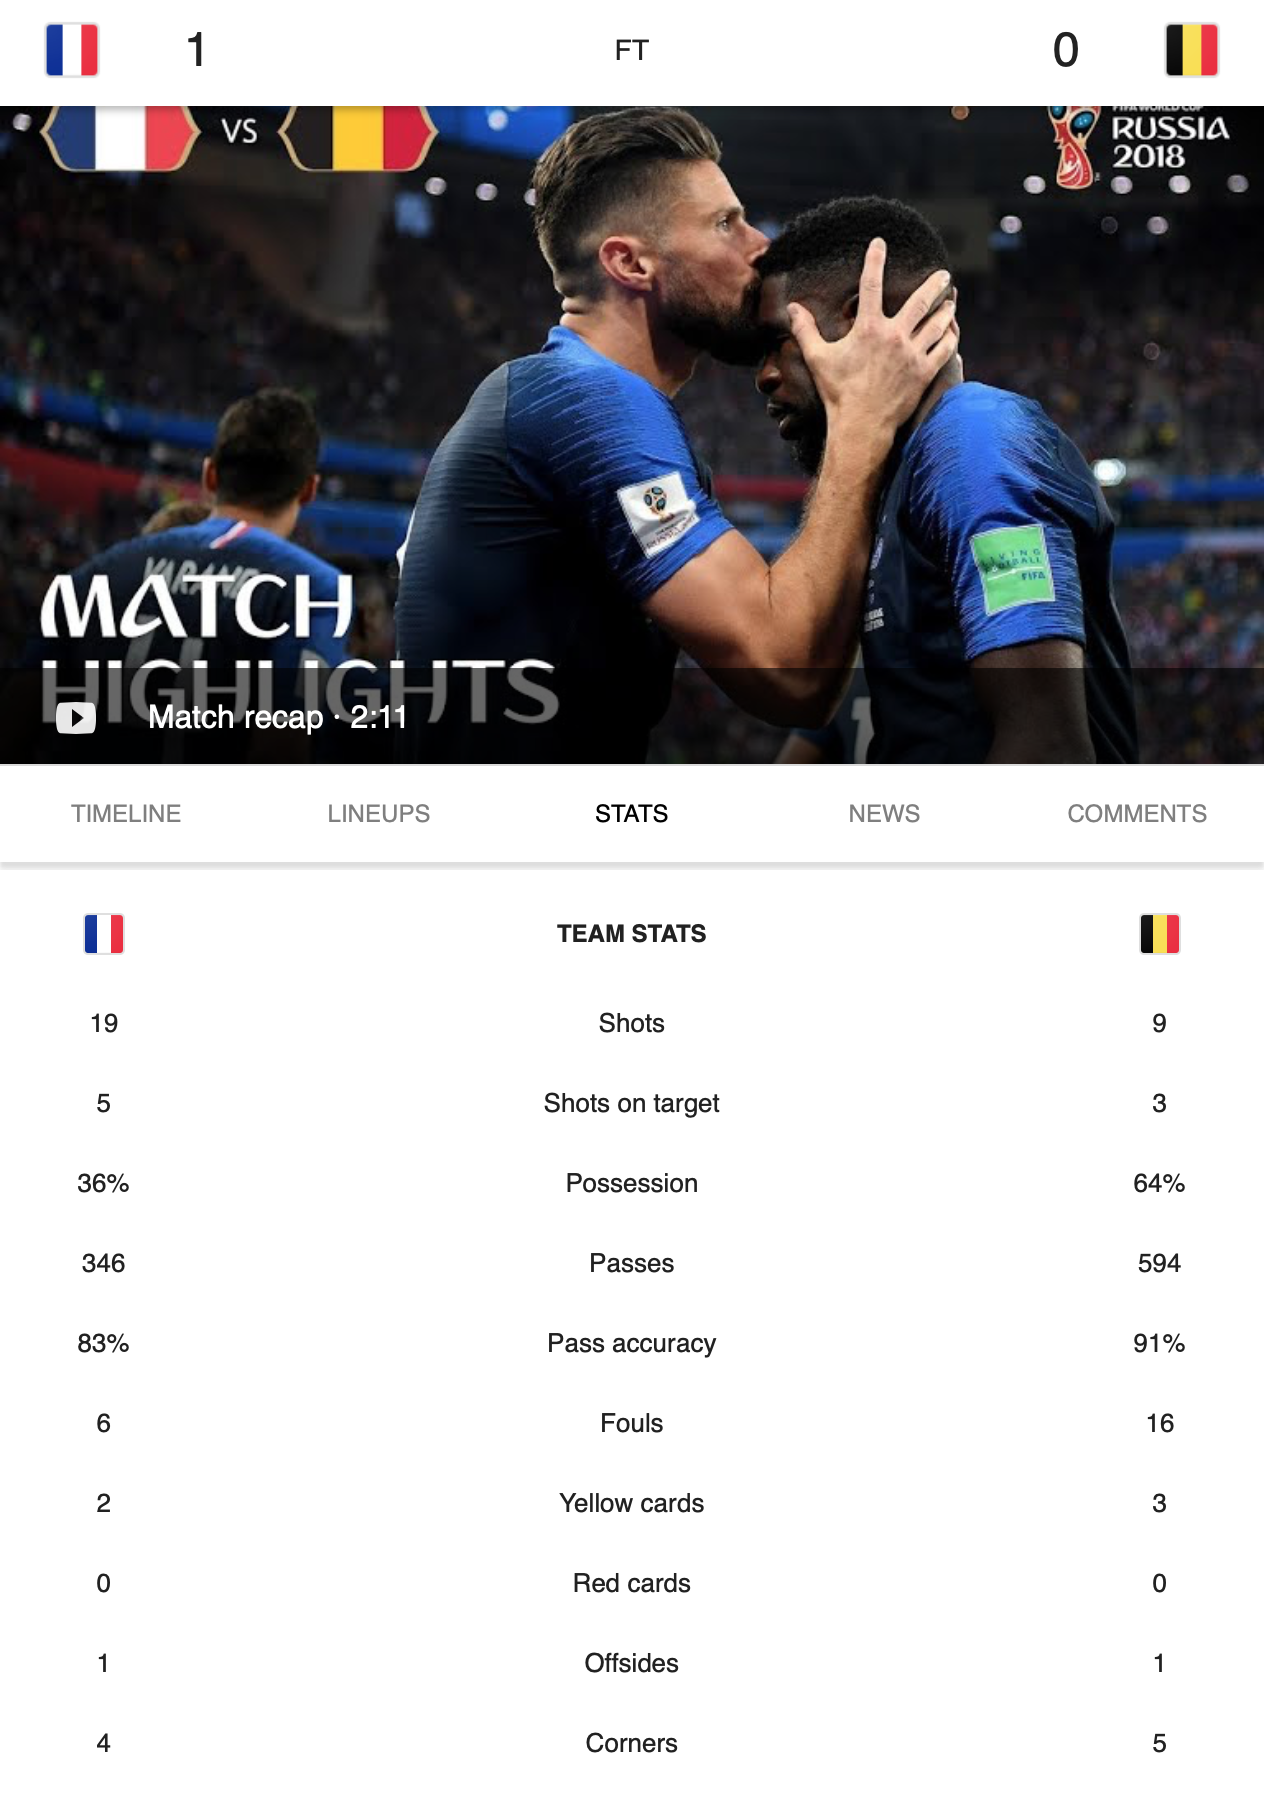

In [48]:
Image("../input/worldcup2018/FranceVsBelgiumResult.png")

**The result is France won over Belgium.  Looking at the stats after the game, Belgium controlled the game with 64%, made 594 passes with 91% accuracy.  It showed that Belgium was a better team.  However, Belgium could not make a lot of shots.  It had only 3 shots on target.  **

**On the other hand, France was a weaker team that could not control of the game, but it made a lot of shots (19 shots).  Whenever France had the ball, they tried to shoot to the goal and 5 of them was on target.  Finally, France scored one and won the game.**

## We can try to analyze the other games like that to see which team has more advantages.  

## 3.2 Croatia vs England ( 2nd quater final)
### 3.2.1 Teams Analysis

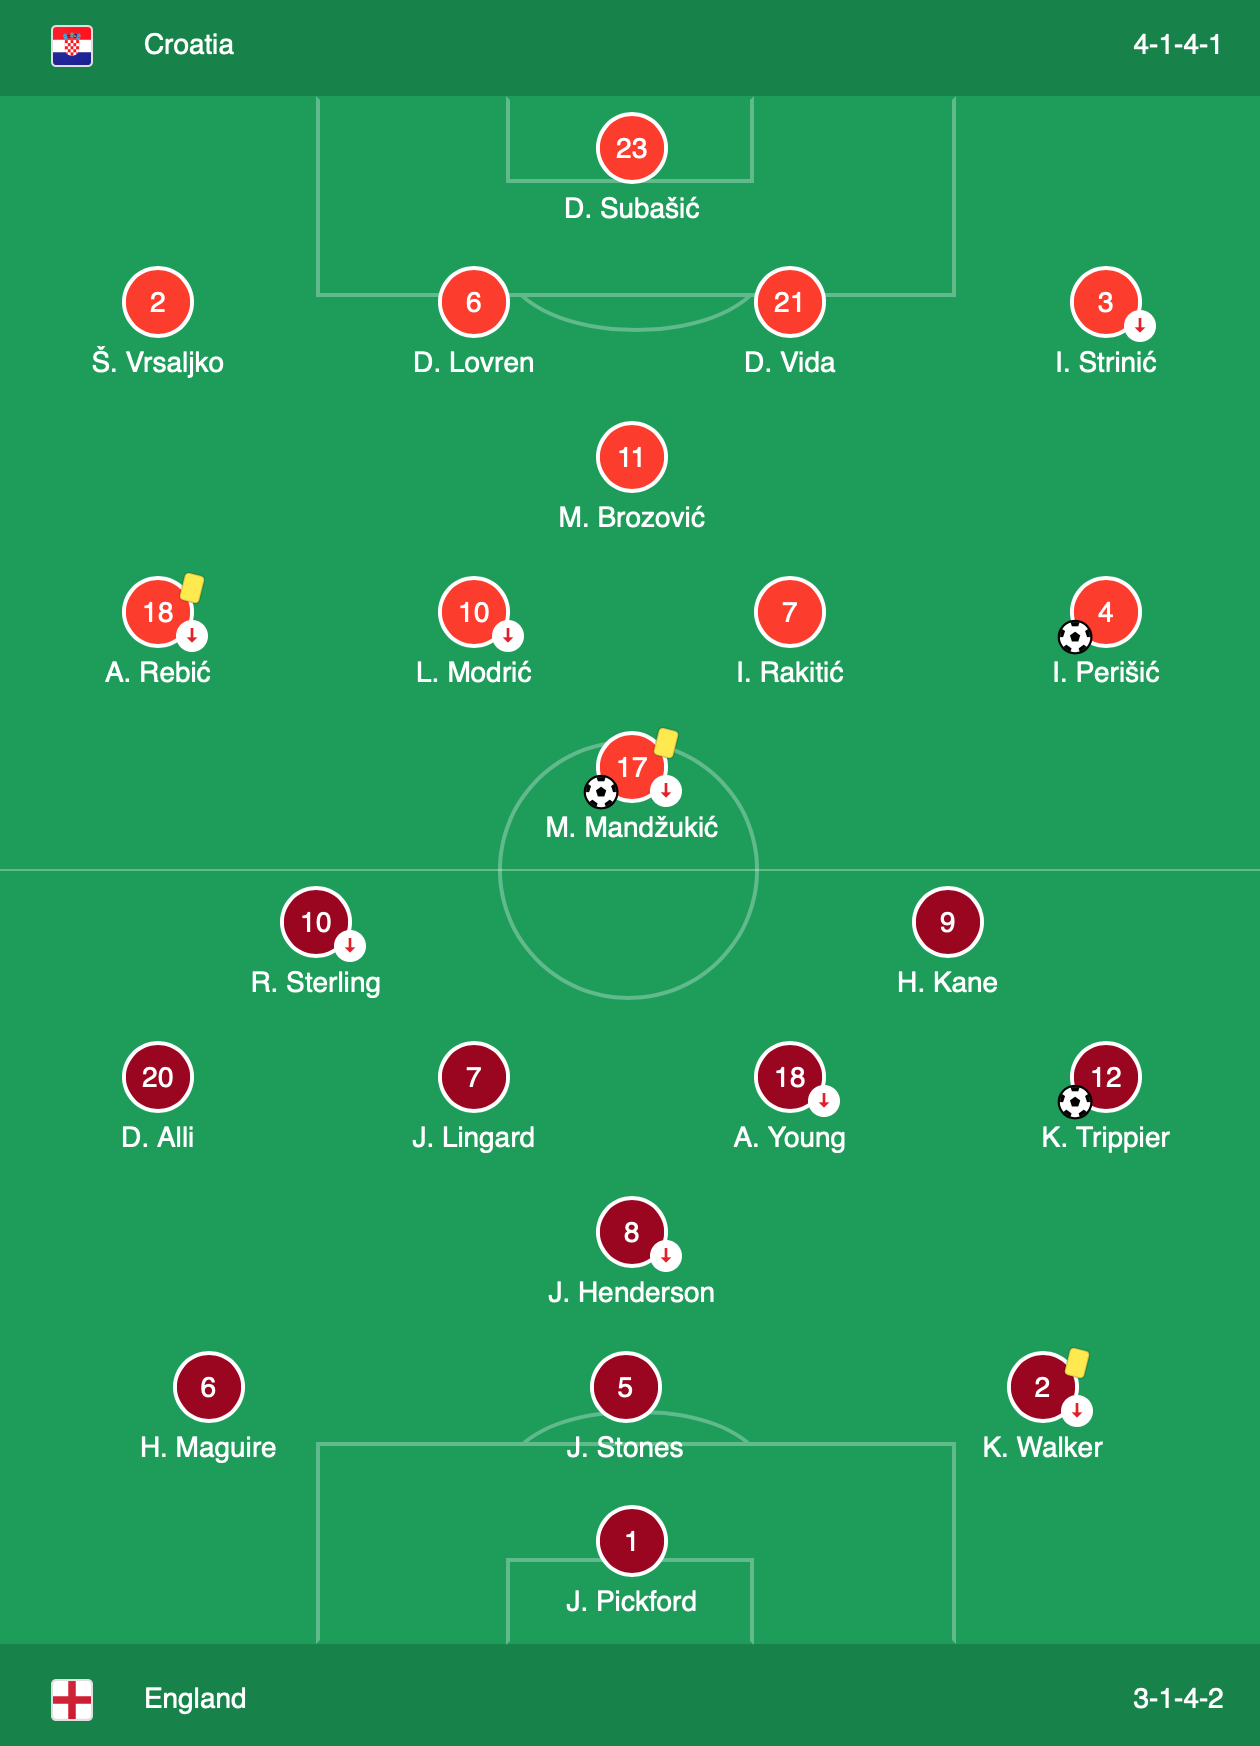

In [49]:
Image("../input/worldcup2018/CroatiaVsEngland.png")

In [50]:
CroatiaPlayers = ["D. Subašić","S. Vrsaljko","D. Lovren","D. Vida","I. Strinić","M. Brozović","A. Rebić","L. Modrić","I. Rakitić","I. Perišić", "M. Mandžukić"]
EnglandPlayers = ["R. Sterling","H. Kane","D. Alli","J. Lingard","A. Young","K. Trippier","J. Henderson", "H. Maguire","J. Stones","K. Walker","J. Pickford"]

In [51]:
all_croatia_players =data[data.Nationality == "Croatia"]
Croatia_lineups = all_croatia_players.iloc[get_location(CroatiaPlayers,all_croatia_players),:]
Croatia_lineups

,Name,Age,Nationality,Overall,Value,AgeRange
14,L. Modrić,31,Croatia,89,57000000.0,Mature
41,I. Rakitić,29,Croatia,87,48500000.0,Mature
76,D. Subašić,32,Croatia,85,22000000.0,Mature
112,I. Perišić,28,Croatia,84,31500000.0,Mature
170,M. Mandžukić,31,Croatia,83,23500000.0,Mature
306,M. Brozović,24,Croatia,81,23000000.0,Mature
339,D. Lovren,27,Croatia,81,17500000.0,Mature
567,S. Vrsaljko,25,Croatia,79,13500000.0,Mature
1908,I. Strinić,29,Croatia,75,5000000.0,Mature
3622,A. Rebić,23,Croatia,72,4200000.0,Young


In Croatia_lineups, we found 11 players.  However, we have a duplicate D. Lovren, and we are missing D. Vida. I found information about D. Vida [here ](https://sofifa.com/player/199206/domagoj-vida/)

* D. Vida: age:29, Overall: 80, Value: 11.5M


In [52]:
# Add missing players to Croatia_lineups dataframe
Croatia_lineups=Croatia_lineups.append({'Name' : 'D. Vida' , 'Age' : 29, 'Nationality': 'Croatia', 'Overall' : 80, 'Value' : 11500000} , ignore_index=True)
Croatia_lineups

,Name,Age,Nationality,Overall,Value,AgeRange
0,L. Modrić,31,Croatia,89,57000000.0,Mature
1,I. Rakitić,29,Croatia,87,48500000.0,Mature
2,D. Subašić,32,Croatia,85,22000000.0,Mature
3,I. Perišić,28,Croatia,84,31500000.0,Mature
4,M. Mandžukić,31,Croatia,83,23500000.0,Mature
5,M. Brozović,24,Croatia,81,23000000.0,Mature
6,D. Lovren,27,Croatia,81,17500000.0,Mature
7,S. Vrsaljko,25,Croatia,79,13500000.0,Mature
8,I. Strinić,29,Croatia,75,5000000.0,Mature
9,A. Rebić,23,Croatia,72,4200000.0,Young


In [53]:
# Remove D. Lovren who has overall score 58.  I will keep D. Lovren with overall score at 81.
Croatia_lineups.drop(index = 10)

,Name,Age,Nationality,Overall,Value,AgeRange
0,L. Modrić,31,Croatia,89,57000000.0,Mature
1,I. Rakitić,29,Croatia,87,48500000.0,Mature
2,D. Subašić,32,Croatia,85,22000000.0,Mature
3,I. Perišić,28,Croatia,84,31500000.0,Mature
4,M. Mandžukić,31,Croatia,83,23500000.0,Mature
5,M. Brozović,24,Croatia,81,23000000.0,Mature
6,D. Lovren,27,Croatia,81,17500000.0,Mature
7,S. Vrsaljko,25,Croatia,79,13500000.0,Mature
8,I. Strinić,29,Croatia,75,5000000.0,Mature
9,A. Rebić,23,Croatia,72,4200000.0,Young


In [54]:
all_england_players =data[data.Nationality == "England"]
England_lineups = all_england_players.iloc[get_location(EnglandPlayers,all_england_players),:]
England_lineups

,Name,Age,Nationality,Overall,Value,AgeRange
46,H. Kane,23,England,86,59000000.0,Young
96,D. Alli,21,England,84,43000000.0,Young
161,K. Walker,27,England,83,24000000.0,Mature
229,R. Sterling,22,England,82,29500000.0,Young
261,J. Henderson,27,England,82,21500000.0,Mature
569,J. Stones,23,England,79,14500000.0,Young
746,J. Lingard,24,England,78,13000000.0,Mature
818,J. Lingard,24,England,78,13000000.0,Mature
907,K. Trippier,26,England,78,10000000.0,Mature
1086,J. Pickford,23,England,77,10000000.0,Young


We found 13 players.  However, we have a duplicate J. Lingard, and K. Walker-Perter who is not in the lineup.  We need to remove those players.

In [55]:
England_lineups.drop(England_lineups.index[[7,12]])

,Name,Age,Nationality,Overall,Value,AgeRange
46,H. Kane,23,England,86,59000000.0,Young
96,D. Alli,21,England,84,43000000.0,Young
161,K. Walker,27,England,83,24000000.0,Mature
229,R. Sterling,22,England,82,29500000.0,Young
261,J. Henderson,27,England,82,21500000.0,Mature
569,J. Stones,23,England,79,14500000.0,Young
746,J. Lingard,24,England,78,13000000.0,Mature
907,K. Trippier,26,England,78,10000000.0,Mature
1086,J. Pickford,23,England,77,10000000.0,Young
1214,H. Maguire,24,England,77,10500000.0,Mature


In [56]:
print("Here is Croatia's average age: {:.2f},comparing against England's average age: {:.2f}.".format(Croatia_lineups.Age.mean(),England_lineups.Age.mean()))
print("We can see England players are younger than Croatia players on average. It means Croatia have more experiences than France. England players are youngers, so they have more strength.")

Here is Croatia's average age: 27.17,comparing against England's average age: 24.23.
We can see England players are younger than Croatia players on average. It means Croatia have more experiences than France. England players are youngers, so they have more strength.


### History Games
#### This is results whenever Croatia play against England in the World Cup history

| Date        | Match          | Score |
| ------------- |:-------------:| -----:|
| 10 Sep 2008	|Croatia v England	| 	1-4
| 09 Sep 2009	|England v Croatia	|  5-1


[Here](https://www.11v11.com/teams/england/tab/opposingTeams/opposition/Croatia/) is where I found that data.

They only played twice, and England won both games.

### 3.2.2 Prediction

### 3.2.3 Result

## 3.3 France vs Croatia ( Final)

### 3.3.1 Teams Analysis

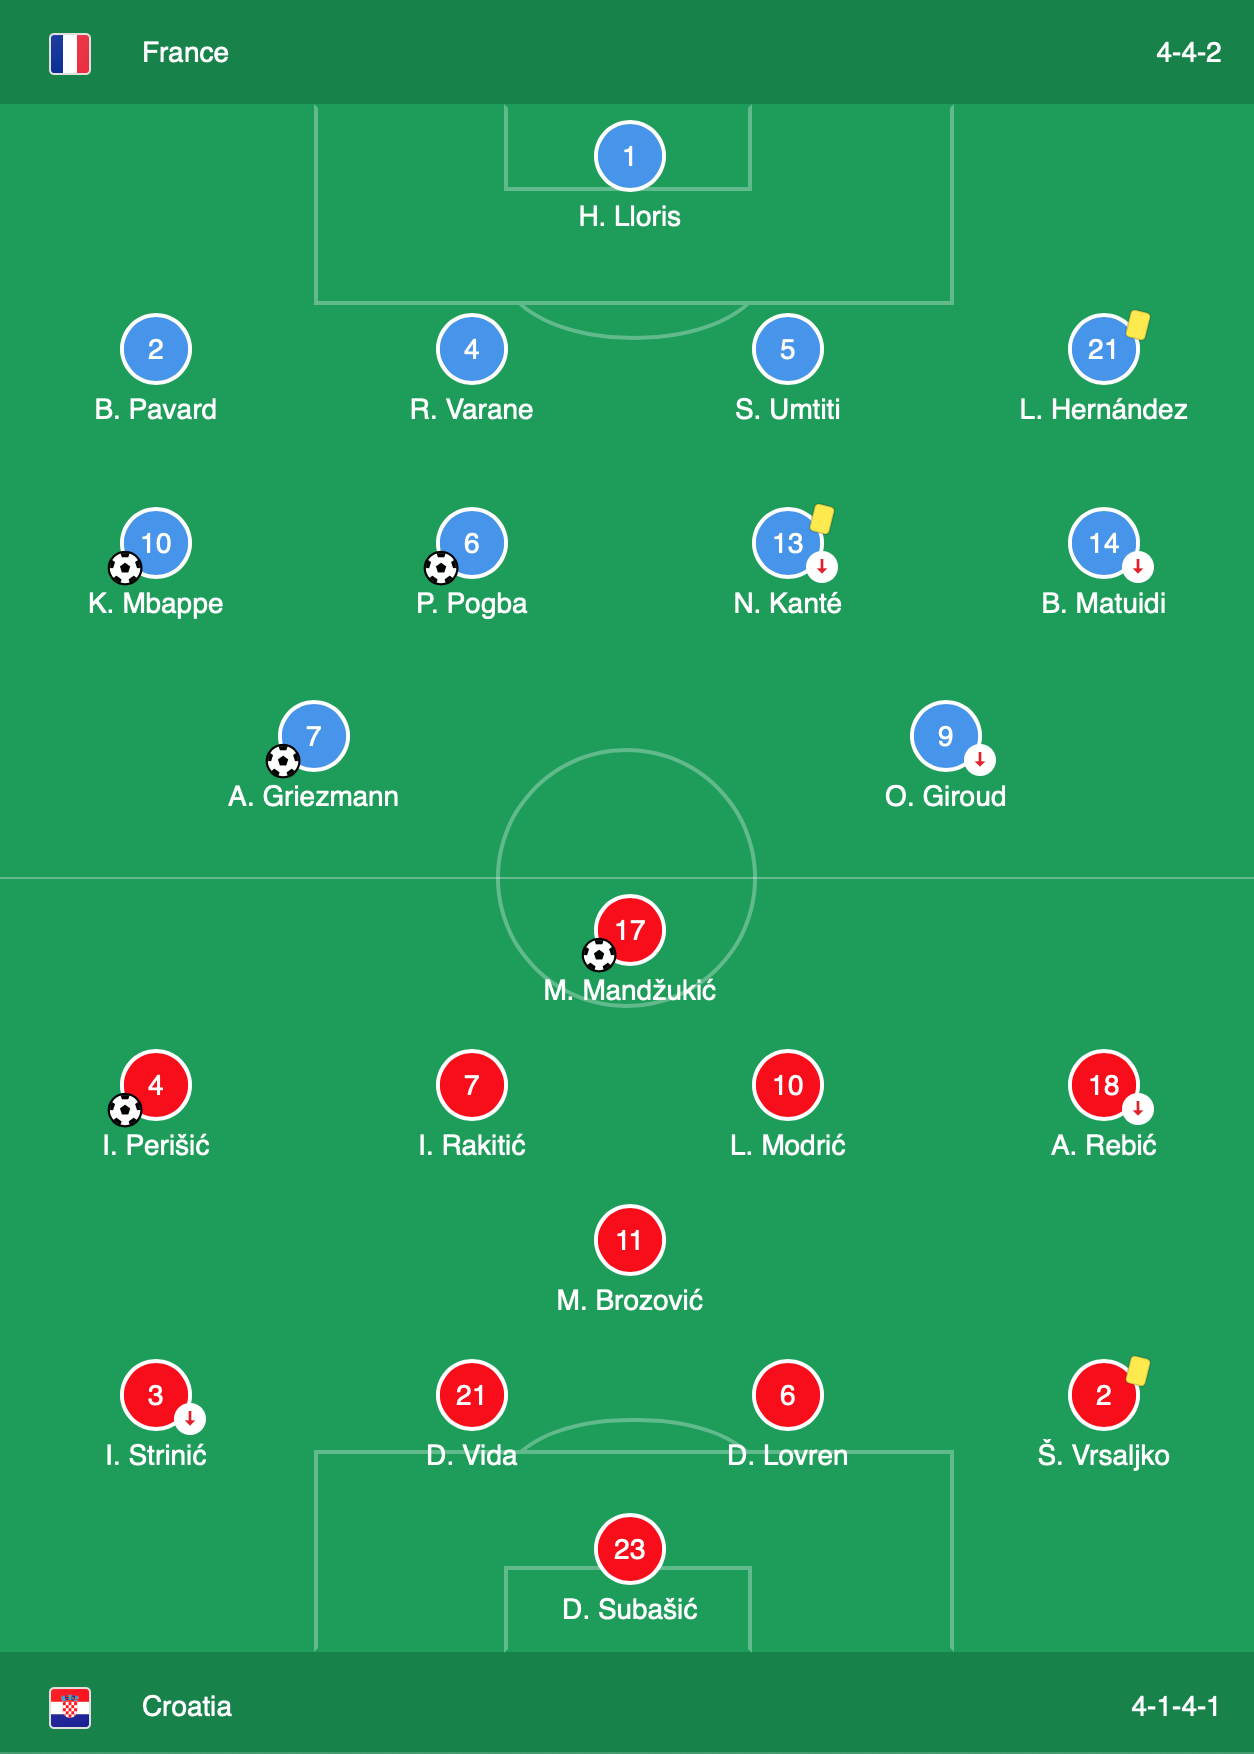

In [57]:
Image("../input/worldcup2018/FranceVsCroatia.png")

### 3.3.2 Prediction

### 3.3.3 Result